# Computer Vision, Assignment 4: Model Fitting and Local Optimization
# By Hafizullah Alizada and Ali Hassani 

In this assignment, you will how to robustly estimate camera parameters and how to jointly optimize the scene geometry. 
You will mainly use RANSAC and Bundle Adjustment.

Please see Canvas for detailed instructions on what is expected for a passing/higher grade.
All computer exercises that are not marked **OPTIONAL** are "mandatory" in the sense described on Canvas.


### Submission Requirements:
Your final lab submission should include:
1. Your edited **notebook file** (`.ipynb`).
2. An **HTML printout** of the executed notebook with all outputs visible: File → Save and export Notebook As → HTML
3. A **pdf report** containing answers to the theoretical exercises (see separate document).


### Reusing functions from prior assignment:
In this assignment, you will build on your prior work. Many of the exercises require you to use functions implemented in assignment 3. To do so most easily, we recommend that you paste those functions into `helpers.py` and import them here by e.g. `from helpers import estimate_F_DLT`. 

In [12]:
# for creating responsive plots
%matplotlib widget  

import cv2
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp

# Note: These functions are provided for your convenience, use them where needed
from supplied import pflat, plot_camera, rital

# Estimate Essential Matrix using RANSAC

#### *Theoretical exercises 1-2* (see pdf)

## Computer Exercise 1
<figure align="center">
    <img alt="left" src="data/round_church1.jpg" width="250px">
&nbsp; &nbsp; &nbsp; &nbsp;
    <img alt="right" src="data/round_church2.jpg" width="250px">
    <img alt="right" src="data/round_church_recon.png" width="250px">
    <figcaption>Figure 1: Two images of a church and an example of the obtained 3D reconstruction.</figcaption>
</figure>

The goal of this exercise is to robustly estimate essential matrix $E$ from point matches between the two images. For this, we will use RANSAC with an eight point solver.

The data provided contains calibration matrix $K$, which is the same for both images, and a cell $\mathbf{x}$ with matched image points for the two images. Note that $\mathbf{x}$ are noisy and contain some fraction of outliers.

In [13]:
# First we supply some preliminaries, just loading images and data
img1 = plt.imread('./data/round_church1.jpg')
img2 = plt.imread('./data/round_church2.jpg')

data = sp.io.loadmat('./data/compEx1data.mat')
K = data["K"]
x = [x.astype(np.float32) for x in data['x'][0]]

### Task 1.1

First, compute the essential matrix $E$ with an eight point algorithm using all the point correspondences. Remember to normalize image points using $K$ beforehand. Then convert it to a fundamental matrix $F$. Recall that in Assignment 3, you created functions `estimate_F_DLT(x1s, x2s)`, `enforce_essential(E_approx)`, and `convert_E_to_F(E,K1,K2)`.

In [14]:
import importlib
import helpers
helpers = importlib.reload(helpers)


# Optional imports
from helpers import estimate_F_DLT, enforce_essential, convert_E_to_F, enforce_fundamental

In [15]:
# ------ Your code here ------

# Insert code where you compute the essential matrix

# Insert code where you transform the essential matrix to a fundamental matrix


# ------ Your code here ------

# get the matched points already loaded as x (list of two arrays)
x1 = x[0]   # 3 x N (pixel homogeneous)
x2 = x[1]   # 3 x N (pixel homogeneous)

# 1) Normalize image points using the calibration matrix K
x1_cal = np.linalg.inv(K) @ x1   # calibrated (normalized) coordinates
x2_cal = np.linalg.inv(K) @ x2

# 2) Estimate E using the eight-point algorithm on normalized coords
#    estimate_F_DLT returns a 3x3 matrix from DLT; for calibrated points
#    this is an approximation of E (up to scale).
F_approx_cal, M, smin, res = estimate_F_DLT(x1_cal, x2_cal)

# 3) Enforce essential matrix constraints (rank-2, equal singular values)
E = enforce_essential(F_approx_cal)

# 4) Convert the essential matrix back to a fundamental matrix in pixel coords
F = convert_E_to_F(E, K, K)

# 5) (optional but recommended) enforce rank-2 on the pixel-space F and normalize
F = enforce_fundamental(F)
F = F / np.linalg.norm(F)

# Quick sanity prints (optional)
print("E shape:", E.shape, "   singular values:", np.linalg.svd(E, compute_uv=False))
print("F shape:", F.shape, "   ||F|| =", np.linalg.norm(F))


E shape: (3, 3)    singular values: [1.00000000e+00 1.00000000e+00 3.06540314e-21]
F shape: (3, 3)    ||F|| = 0.9999999999999999


### Task 1.2 

Compute the epipolar lines $\mathbf{l}_2 = F\mathbf{x}_1$ and $\mathbf{l}_1 = F^T\mathbf{x}_2$. Compute the RMS distance between the image points ($\mathbf{x}_1$ and $\mathbf{x}_2$) and corresponding epipolar lines ($\mathbf{l}_1$ and $\mathbf{l}_2$, respectively). 

\begin{align}
& e_{RMS} = \sqrt{\frac{1}{2m}
\left(
\sum_{i=1}^{m} d^2({\mathbf{x}_1}_i,{\mathbf{l}_1}_i) + 
\sum_{i=1}^{m} d^2({\mathbf{x}_2}_i,{\mathbf{l}_2}_i)
\right)
},\nonumber \\
& \text{where }~d(\mathbf{x}, \mathbf{l}) = \frac{|l_{1}x_{1}+l_{2}x_{2}+l_{3}|}{\sqrt{l_{1}^2+l_{2}^2}}.
\end{align}

In Assignment 3, you implemented the distances $d(\mathbf{x}, \mathbf{l})$ from image points to the corresponding epipolar lines for the second image in the function `compute_epipolar_errors(F, x1s, x2s)`.


**HINT:** If you transpose the fundamental matrix and change the order of the correpondences, i.e. run `compute_epipolar_errors(F.T, x2s, x1s)` you can obtain the errors to the epipolar lines in the first image.

In [16]:
import importlib
import helpers
importlib.reload(helpers)


# Optional imports
from helpers import compute_epipolar_errors 

In [17]:
# ------ Your code here ------

# Compute the epipolar lines, l1 and l2 

# Compute the RMS distance


# ------ Your code here ------

# Compute the epipolar lines in pixel coordinates
# l2: epipolar lines in image 2 corresponding to x1
# l1: epipolar lines in image 1 corresponding to x2
l2 = F @ x1
l1 = F.T @ x2

# Compute distances from points to corresponding epipolar lines (in pixels)
# d2: distances of x2 points to lines l2 (image 2)
# d1: distances of x1 points to lines l1 (image 1)
d2 = compute_epipolar_errors(F, x1, x2)    # uses (F, x1s, x2s)
d1 = compute_epipolar_errors(F.T, x2, x1)  # distances in image1

# number of correspondences
m = x1.shape[1]

# RMS as defined in the assignment
eRMS = np.sqrt((np.sum(d1**2) + np.sum(d2**2)) / (2.0 * m))

# Print results
print(f"Computed epipolar lines l1 (image1) and l2 (image2).")
print(f"RMS epipolar error e_RMS = {eRMS:.6f} pixels")

# optional sanity checks
assert l1.shape == (3, m) and l2.shape == (3, m), "epipolar lines shapes unexpected"


Computed epipolar lines l1 (image1) and l2 (image2).
RMS epipolar error e_RMS = 155.958322 pixels


### Task 1.3

Plot two separate histograms with 100 bins for the epipolar errors $\{d({\mathbf{x}_1}_i,{\mathbf{l}_1}_i)\}$ in the first image and $\{d({\mathbf{x}_2}_i,{\mathbf{l}_2}_i)\}$ in the second image, respectively. See for example your solution to Assignment 3 Computer Exercise 2.2 for some code on plotting histograms.

Image1: mean = 61.334 px, median = 12.421 px, max = 1218.108 px
Image2: mean = 63.469 px, median = 13.709 px, max = 1079.779 px


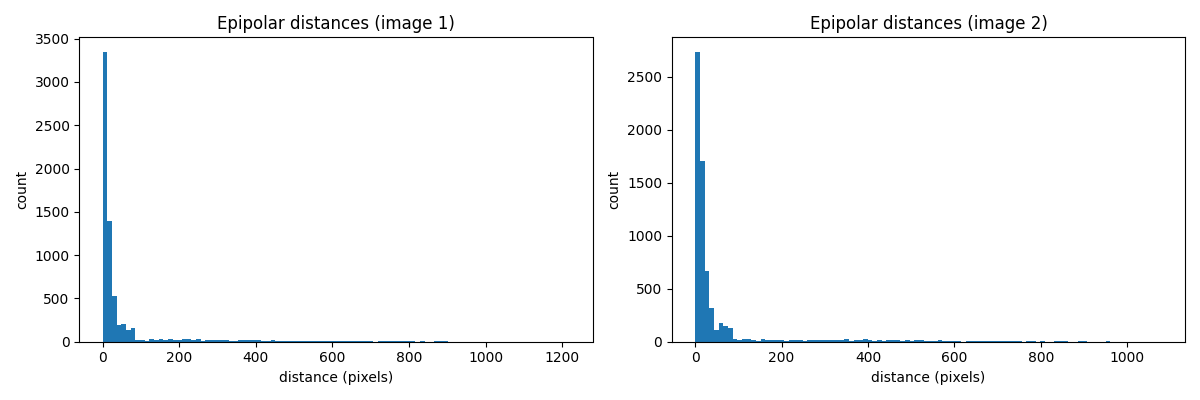

In [18]:
# ------ Your code here ------

# ------ Your code here ------

import matplotlib.pyplot as plt
import numpy as np

# d1: distances in image1 (from Task 1.2)
# d2: distances in image2 (from Task 1.2)

# Basic stats
mean_d1, mean_d2 = np.mean(d1), np.mean(d2)
med_d1, med_d2 = np.median(d1), np.median(d2)
max_d1, max_d2 = np.max(d1), np.max(d2)

print(f"Image1: mean = {mean_d1:.3f} px, median = {med_d1:.3f} px, max = {max_d1:.3f} px")
print(f"Image2: mean = {mean_d2:.3f} px, median = {med_d2:.3f} px, max = {max_d2:.3f} px")

# Plot two histograms (100 bins each)
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.hist(d1, bins=100)
plt.title("Epipolar distances (image 1)")
plt.xlabel("distance (pixels)")
plt.ylabel("count")

plt.subplot(1,2,2)
plt.hist(d2, bins=100)
plt.title("Epipolar distances (image 2)")
plt.xlabel("distance (pixels)")
plt.ylabel("count")

plt.tight_layout()
plt.show()


### Task 1.4

Pick 20 points in the first image at random and plot these in the same figure as the image. Also plot the corresponding epipolar lines in the same image using the function `rital`. Repeat the plot for the second image.

Q: **Do the plots look reasonable, are points close to the epipolar lines? If not, what do you think could be the cause of the bad estimate?** 

A: [Insert your answer]

In [19]:
# ------ Your code here ------

### Task 1.5

Next, use RANSAC to robustly compute $E$. Create a function `estimate_E_robust(x1, x2, eps)` that does it, where `eps` is the inlier threshold. Remember again to normalize `x1` and `x2` using $K$ beforehand. Note that for this problem of estimating $E$, a point correspondence $({\mathbf{x}_1}_i, {\mathbf{x}_2}_i)$ is a single measurement. Use the same eight point solver as above.

Note that this time only a subset of correspondences will be used by this solver (since in the RANSAC loop, you first randomly sample a subset of correspondences and then compute candidate $E$ from this subset).

Finally, to make RANSAC work, you need to implement an error function that measures how far a single measurement ($({\mathbf{x}_1}_i, {\mathbf{x}_2}_i)$) is to the candidate model ($E$). Use the following error function: $\frac12 \left ( d^2({\mathbf{x}_1}_i,{\mathbf{l}_1}_i) + d^2({\mathbf{x}_2}_i,{\mathbf{l}_2}_i)\right )$, where the epipolar lines ${\mathbf{l}_j}_i$ are computed as before but using $E$ (and therefore are normalized). This error should be familiar to you based on the previous exercises, reuse your implementation from there!

A suggested inlier threshold is 2px (which should also be normalized, see function description below). 

Q: **How many inliers did you get for the returned solution of $E$?**

A: [Insert your answer]

In [20]:
def estimate_E_robust(x1, x2, eps, seed=None):
    """
    RANSAC estimate of essential matrix using normalized correspondences x1 and x2 and a normalized threshold.
    Note: Make sure to normalize things before using it in this function!
    -------------------------------------------
    x1: Normalized keypoints in image 1 - 3xN np.array or 2xN np.array, as you desire 
    x2: Normalized keypoints in image 2 - 3xN np.array or 2xN np.array, as you desire 
    eps: Normalized inlier threshold - float

    Returns:
    E: 3x3 essential matrix
    inliers: The inlier points
    errs: The epipolar errors
    iters: How many iterations it took
    """
    # TIPS: 
    # * You can use the already created functions, enforce_essential, estimate_F_DLT, and compute_epipolar_errors
    # * Normalizing the pixel threshold can be done by e.g. eps = threshold_px / K[0,0]
    # * To create an estimate for E using DLT for a random subset of calibrated correspondences...
    # ...you can chain your functions like: E = enforce_essential(estimate_F_DLT(x1[:, randind], x2[:, randind]))

    # * Pseudo code for computing inliers:
    # e1 = compute_epipolar_errors(E, x1, x2)**2 
    # e2 = compute_epipolar_errors(E.T, x2, x1)**2
    # inliers = (1/2)*(e1+e2) < eps**2
    
    # ------ Your code here ------
    return E, inliers, errs, iters

### Task 1.6

Again, compute the RMS distance between the image points and corresponding estimated epipolar lines in both images. Also plot a histogram of epipolar errors for both images as before. 

Q: **Which is the better estimate of the essential matrix, and why?** Repeat plotting 20 random points with the corresponding epipolar lines, but this time pick random points from the subset of correspondences that are ***inliers***.

A: [Insert your answer]

In [21]:
# ------ Your code here ------

## Computer Exercise 2
<figure align="center">
    <img alt="left" src="data/fountain1.png" width="250px">
&nbsp; &nbsp; &nbsp; &nbsp;
    <img alt="right" src="data/fountain2.png" width="250px">
    <img alt="right" src="data/fountain_recon.png" width="250px">
    <figcaption>Figure 2: Two images of a fountain and an example of the obtained 3D reconstruction.</figcaption>
</figure>

In this exercise you will build a 2-view reconstruction pipeline that connects feature extraction,
matching, robust essential matrix estimation from the previous computer exercise, and triangulation.

You can use the two supplied images from the data and the intrinsics provided. We load the required data for your convenience below:

In [22]:
data = sp.io.loadmat('./data/compEx2data.mat')
K = data['K']
img1 = (plt.imread('./data/fountain1.png') * 255).astype('uint8')
img2 = (plt.imread('./data/fountain2.png') * 255).astype('uint8')

### Task 2.1

We will begin by computing SIFT features and matching them. Since OpenCV has quite a difficult API for this we have supplied some code snippets. And you already learned much of the basics of this from Assignment 2, so we provide some basic code to get you started.

The implementation is based on their official guide for image matching (https://docs.opencv.org/3.4/dc/dc3/tutorial_py_matcher.html) and uses Lowe's ratio test to filter out matches that are too similar, this should be similar to what you have done in previous assignments.

In [23]:
# Some supplied code on how to compute matches using OpenCV

from cv2 import SIFT_create, cvtColor, COLOR_RGB2GRAY, FlannBasedMatcher, drawMatchesKnn
rgb2gray = lambda img: cvtColor(img, COLOR_RGB2GRAY)
sift = SIFT_create(contrastThreshold=0.02, edgeThreshold=10, nOctaveLayers=3)

# We detect keypoints and simultaneously describe them using SIFT
kp1, des1 = sift.detectAndCompute(rgb2gray(img1),None)
kp2, des2 = sift.detectAndCompute(rgb2gray(img2),None)

# We use a k-NN-like system to find the most similar descriptions
all_matches = FlannBasedMatcher().knnMatch(des1, des2, k=2)
# Apply ratio test
# Here we filter out matches that are too similar to other matches (because then they are likely wrong)
# This is standard in OpenCV, see https://docs.opencv.org/4.x/dc/dc3/tutorial_py_matcher.html
matches = []
for m,n in all_matches:
    if m.distance < 0.75*n.distance:
        matches.append([m])

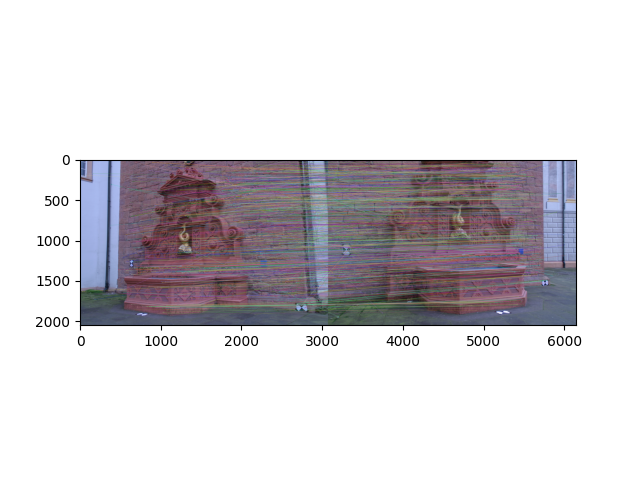

(<matplotlib.image.AxesImage at 0x2aae876f410>, None)

In [24]:
# Run this code for a simple plot of the filtered matches

# Just making sure no other figures are impacting this one
plt.close()
plt.clf()   
plt.cla() 
# Here is some supplied code from https://docs.opencv.org/4.x/dc/dc3/tutorial_py_matcher.html
# Feel free to play around with it
img3 = drawMatchesKnn(img1,kp1,img2,kp2,matches,None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
plt.imshow(img3,),plt.show()

Q: **Run the code above. Do the matches look reasonable?**

A: [Insert your answer]

Q: **How many SIFT features did you find for the two images, respectively? How many total matches did you find? How many good matches did you find after the ratio test?**

A: [Insert your answer]

In [25]:
# ------ Your code here ------

# Count SIFT features per image
n_kp1 = 0 if kp1 is None else len(kp1)
n_kp2 = 0 if kp2 is None else len(kp2)

# Count number of total matches
n_knn_lists = 0 if all_matches is None else len(all_matches)
# Count the number of good matches after the ratio-test
n_knn_pairs = 0 if all_matches is None else sum(len(p) for p in all_matches)
n_good = 0 if matches is None else len(matches)

print(f"SIFT-features (bild 1): {n_kp1}")
print(f"SIFT-features (bild 2): {n_kp2}")
print(f"Totala knnMatch-listor (k=2): {n_knn_lists}")
print(f"Totala match-objekt i knn-resultatet: {n_knn_pairs}")
print(f"Bra matchningar efter ratio test: {n_good}")

SIFT-features (bild 1): 19410
SIFT-features (bild 2): 17618
Totala knnMatch-listor (k=2): 19410
Totala match-objekt i knn-resultatet: 38820
Bra matchningar efter ratio test: 1030


Now we supply a little more code just to make it easier. We extract the keypoints corresponding to the good matches and save them as x1 and x2. We do this because currently the type of kp1 etc... are OpenCV specific

In [26]:
# Supplied code for extracting numpy arrays from matching keypoints
# Note, x1 and x2 are in homogenous coordinates after this
x1 = np.array([[kp1[match[0].queryIdx].pt[0], kp1[match[0].queryIdx].pt[1]] for match in matches])
x2 = np.array([[kp2[match[0].trainIdx].pt[0], kp2[match[0].trainIdx].pt[1]] for match in matches])
x1 = np.vstack((x1.T, np.ones(x1.shape[0])))
x2 = np.vstack((x2.T, np.ones(x2.shape[0])))
x = np.array([x1, x2])

### Task 2.2

Now you should find the essential matrix describing the transformation between the two images.
Because not all matches are correct, you need to use RANSAC to find a set of good correspondences (inliers). 
To estimate the essential matrix use the function `estimate_E_robust(x1,x2,eps)` that you created in the previous computer exercise.

Q: **How many inliers did you find?**

A: [Insert your answer]

In [27]:
def estimate_E_robust(x1, x2, eps, seed=None):

    # ------ Your code here ------
    x1 = np.asarray(x1)
    x2 = np.asarray(x2)

    if x1.shape[0] == 2:
        x1 = np.vstack((x1, np.ones((1, x1.shape[1]))))
    if x2.shape[0] == 2:
        x2 = np.vstack((x2, np.ones((1, x2.shape[1]))))

    N = x1.shape[1]
    s = 8
    max_iters = 5000
    stop_ratio = 0.80

    rng = np.random.default_rng(seed)

    best_E = None
    best_inliers = None
    best_errs = None
    best_num = -1

    iters = 0
    while iters < max_iters:
        iters += 1

        randind = rng.choice(N, size=s, replace=False)

        F_approx, *_ = estimate_F_DLT(x1[:, randind], x2[:, randind])
        E_cand = enforce_essential(F_approx)

        e1 = compute_epipolar_errors(E_cand, x1, x2)
        e2 = compute_epipolar_errors(E_cand.T, x2, x1)
        errs = 0.5 * (e1**2 + e2**2)

        inliers = errs < eps**2
        num = int(np.sum(inliers))

        if num > best_num:
            best_num = num
            best_E = E_cand
            best_inliers = inliers
            best_errs = errs

            if best_num / N >= stop_ratio:
                break

    if best_inliers is None or int(np.sum(best_inliers)) < s:
        F_approx, *_ = estimate_F_DLT(x1, x2)
        E = enforce_essential(F_approx)
    else:
        F_approx, *_ = estimate_F_DLT(x1[:, best_inliers], x2[:, best_inliers])
        E = enforce_essential(F_approx)

    e1 = compute_epipolar_errors(E, x1, x2)
    e2 = compute_epipolar_errors(E.T, x2, x1)
    errs = 0.5 * (e1**2 + e2**2)
    inliers = errs < eps**2

    return E, inliers, errs, iters
E, inliers, errs, iters = estimate_E_robust(x1n, x2n, eps)
print(int(np.sum(inliers)))


435


### Task 2.3

After getting the robust essential matrix estimation, you should find the camera matrix of the second view. Remember that there are 4 possible solutions (see Theoretical Exercise 7 of HA3)! You should pick the solution that has more points in front of the camera. Remember, in Assigment 3 you implemented `extract_P_from_E(E)`

**Hint:** You need to perform triangulation by using a function from a previous computer exercise. The 3D points X and the 2d correspondences x1 and x2 wil also be needed for the next task in this assignment!

Q: **Which of the solutions seems correct to you?**

A: [Insert your answer]

In [28]:
# Optional import
from helpers import extract_P_from_E

### Summary of reconstruction pipeline

In summary, you have performed a 2d-view reconstruction pipeline consisting of the following steps:
1. **Load the two images**, find SIFT features, and match them.

2. **Estimate the essential matrix** robustly using  
   `estimate_E_robust(x1, x2, eps)`.

3. **Compute the four possible camera matrix pairs** for the essential matrix, and for each pair:
   1. Triangulate the 3D points using the camera matrix pair and the matched image points.
   2. Compute the camera centers and principal directions of both cameras.
   3. Plot everything in 3D.

4. **Choose the correct solution** (out of the four) by selecting the one that yields the highest number of 3D points (inliers) lying in front of the cameras.  

The final visualization should resemble the right-most result in the first Figure of Computer Exercise 2 after removing most outliers.

This pipeline will come in handy for the project and somewhat resembles the first stage in any modern SfM pipeline like [COLMAP](https://github.com/colmap/colmap).

#### *Theoretical exercises 3* (see pdf)

## Computer Exercise 3

In this exercise you will use the solution from Computer Exercise 2 as a starting point and locally improve it using the Levenberg-Marquardt method. If you have doubts about the correctness of your solution from the earlier exercise, you can instead use the provided data in `compEx3data.mat` as starting solution (you can load it like `data = sp.io.loadmat('./data/compEx3data.mat')` and then use that for your x and camera matrices).

The goal is to refine the solution **3D points (not camera matrices, those you can assume fixed**).
You will loop over the 3D points and update them one by one using Levenberg-Marquardt (LM), please see the lecture notes or [Wikipedia page on Levenberg–Marquardt](https://en.wikipedia.org/wiki/Levenberg%E2%80%93Marquardt_algorithm) for more information.

In short, LM is an iterative method for minimizing a non-linear least squares objective
\begin{equation}
   F(v)=\|r(v)\|^2, 
\end{equation}
with respect to $v$.
In LM, the update is given by
\begin{equation}
\delta v =  - (J(v)^TJ(v)+\mu I)^{-1}J(v)^Tr(v),
\end{equation}
where $J(v)$ is the Jacobian of $r(v)$ at $v$.
Here $\mu>0$ is a damping factor that is adjusted adaptively and $v$ is the previous solution.
The new solution is $v+\delta v$ and we iterate until convergence (or for a fixed number of iterations).

We can also define the **reprojection error** to be: $\sum_{i=1}^m \left\|r_{i}(X_j) \right\|^2 $ (as in Equation (2) in the Theoretical Exercises)

In our setting, we have $v=X_j$ and $r(v)=r(X_j)$. Please see the main PDF for some more details about the definition of $r$ (e.g. Equation (3) for the definition).

You will have to implement three functions in this exercise:

1. `(err,res) = compute_reprojection_error(P_1,P_2,X_j,x_1j,x_2j)`: a function that computes the reprojection error ($\sum_{i=1}^m \left\|r_{i}(X_j) \right\|^2 $) given two cameras $P_i$, a 3D point $X_j$ and 2D points $x_{ij}$ in the images corresponding to the cameras $P_i$ and the 3D point $X_j$. It also returns the values of all the individual residuals as a second output, i.e., the residual vector $r(\mathbf{X}_j)$.
    
2. `(r,J) = linearize_reproj_err(P_1,P_2,X_j,x_1j,x_2j)`: a function that computes the linearization ($r$ and $J$) as described in Equation (7) in the Theoretical Exercises.
    
3. `delta_X_j = compute_update(r, J, mu)`: a function that computes the LM-update given $r$, $J$ and $\mu$ as described in Equation (9) in the Theoretical Exercises.

The idea is now to use *decoupled* LM, i.e. loop over the 3D points and refine them one by one.

Let's first start by implementing the functions in code!

**NOTE**: Below we have provided suggestion for the function signatures. However, you are free to implement the actual functions however you'd like. For example, you don't have to take the inputs and outputs on the exact form we suggest. This is one way to store the Jacobians, residuals, etc..., feel free to decide how you feel is best.

In [29]:
# Random useful commands:

# Computes the LM update .
# C = J.T @ J + mu * np.eye(J.shape[1])
# c = J.T @ r
# delta = -np.linalg.solve(C, c)

In [30]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

def compute_reprojection_error(P_1, P_2, X_j, x_1j, x_2j):
    """
    Compute the reprojection error for a single 3D point.

    Parameters
    ----------
    P_1, P_2 : ndarray (3, 4)
        Projection matrices.

    X_j : ndarray (4,)
        3D homogeneous point.

    x_1j, x_2j : ndarray (2,)
        Observed image positions.

    Returns
    -------
    err : float 
        Reprojection error.

    r : Residual vector. For example, an ndarray of shape (2, 2)
        However, you can decide in your own implementation.
    """
    # ------ Your code here ------
    X_j = np.asarray(X_j).reshape(-1)
    if X_j.size == 3:
        Xh = np.hstack([X_j, 1.0])
    else:
        Xh = X_j.copy()
        if abs(Xh[-1]) < 1e-12:
            Xh[-1] = 1.0
        Xh = Xh / Xh[-1]

    def proj(P, Xh):
        y = P @ Xh
        z = y[2] if abs(y[2]) > 1e-12 else (1e-12 if y[2] >= 0 else -1e-12)
        return np.array([y[0]/z, y[1]/z], dtype=float)

    x1_hat = proj(P_1, Xh)
    x2_hat = proj(P_2, Xh)

    r = np.hstack([x1_hat - x_1j, x2_hat - x_2j]).astype(float)
    err = float(r @ r)
    return err, r

In [31]:
def linearize_reproj_err(P_1, P_2, X_j, x_1j, x_2j):
    """
    Linearize the reprojection error for a single 3D point observed in two views.

    Parameters
    ----------
    P_1, P_2 : ndarray (3, 4)
        Camera matrices.

    X_j : ndarray (4,)
        Homogeneous 3D point.

    x_1j, x_2j : ndarray (2,)
        Observed image coordinates for this point in cameras 1 and 2.

    Returns
    -------
    r : Linearization of r. For example an ndarray of shape (4,) representing concatenated reprojection residuals: [r1_x, r1_y, r2_x, r2_y].
        However, you can decide for yourself how you want to store this.

    J : Linearization of J. For example, an ndarray of shape (4, 4) representing a concatenation of the two Jacobians
        However, you can decide for yourself how you want to store this.

    Notes
    -----
    This creates the linear system used in Levenberg-Marquardt.
    """
    # ------ Your code here ------
    X_j = np.asarray(X_j).reshape(-1)
    if X_j.size == 3:
        Xh = np.hstack([X_j, 1.0])
    else:
        Xh = X_j.copy()
        if abs(Xh[-1]) < 1e-12:
            Xh[-1] = 1.0
        Xh = Xh / Xh[-1]

    X = Xh[:3]

    def proj_and_J(P, X):
        p1 = P[0, :3]; p2 = P[1, :3]; p3 = P[2, :3]
        p14 = P[0, 3];  p24 = P[1, 3];  p34 = P[2, 3]

        a = p1 @ X + p14
        b = p2 @ X + p24
        c = p3 @ X + p34
        if abs(c) < 1e-12:
            c = 1e-12 if c >= 0 else -1e-12

        u = a / c
        v = b / c

        du = (p1 * c - a * p3) / (c * c)
        dv = (p2 * c - b * p3) / (c * c)
        J = np.vstack([du, dv])
        return np.array([u, v], dtype=float), J

    x1_hat, J1 = proj_and_J(P_1, X)
    x2_hat, J2 = proj_and_J(P_2, X)

    r = np.hstack([x1_hat - x_1j, x2_hat - x_2j]).astype(float)
    J = np.vstack([J1, J2]).astype(float)
    return r, J


In [32]:
def compute_update(r, J, mu):
    """
    Compute the LM update step for a single 3D point.

    Parameters
    ----------
    r : For example, ndarray of shape (4,)
        Residual vector.

    J : For example, ndarray of shape (4, 4)
        Jacobian of the residuals w.r.t. the 3D point.

    mu : float
        Levenberg–Marquardt damping parameter.

    Returns
    -------
    delta : ndarray of shape (4,)
        Update ΔX to apply to the 3D point.

    Notes
    -----
    Solves:
        (JᵀJ + μI) δ = -Jᵀ r
    """
    # ------ Your code here ------
    r = np.asarray(r).reshape(-1)
    J = np.asarray(J)
    C = J.T @ J + mu * np.eye(J.shape[1])
    c = J.T @ r
    delta = -np.linalg.solve(C, c)
    return delta


Median reprojection error before bundle adjustment: 3174771.235568857
Total reprojection error before bundle adjustment: 495975840.4237282
Median reprojection error after bundle adjustment: 2955179.288897215
Total reprojection error after bundle adjustment: 471735563.7544971


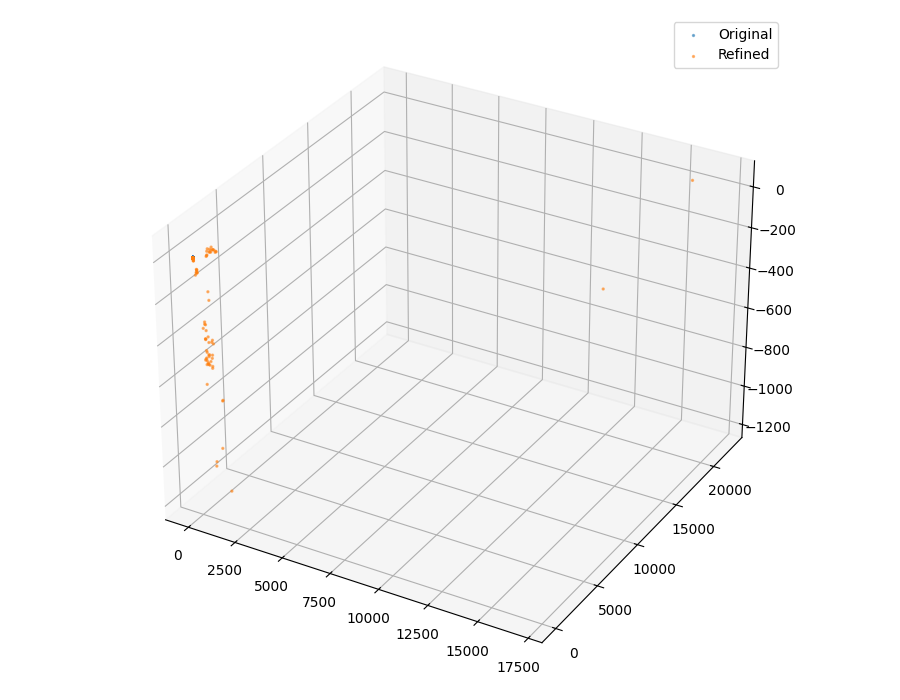

In [33]:
# ------ Your code here ------

import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

try:
    P1
    P2
    X
    x1
    x2
except NameError:
    data = sp.io.loadmat('./data/compEx3data.mat')
    if 'P1' in data: P1 = data['P1']
    if 'P2' in data: P2 = data['P2']
    if 'P_1' in data: P1 = data['P_1']
    if 'P_2' in data: P2 = data['P_2']
    if 'X' in data:  X  = data['X']
    if 'x' in data:
        xx = data['x'][0]
        x1 = xx[0]
        x2 = xx[1]

def to_xy(xh):
    xh = np.asarray(xh)
    if xh.shape[0] == 3:
        xh = xh / (xh[2:3, :] + 1e-12)
        return xh[:2, :]
    return xh

x1xy = to_xy(x1)
x2xy = to_xy(x2)

X0 = np.asarray(X).copy()
if X0.shape[0] == 4:
    X0 = X0 / (X0[3:4, :] + 1e-12)
else:
    X0 = np.vstack((X0, np.ones((1, X0.shape[1]))))
Xref = X0.copy()

N = Xref.shape[1]

# Print the median reprojection error before bundle adjustment
errs_before = np.zeros(N)
for j in range(N):
    e, _ = compute_reprojection_error(P1, P2, Xref[:, j], x1xy[:, j], x2xy[:, j])
    errs_before[j] = e

print("Median reprojection error before bundle adjustment:", float(np.median(errs_before)))
print("Total reprojection error before bundle adjustment:", float(np.sum(errs_before)))

# Perform bundle adjustment by looping through your N points
# For each point, compute the Levenberg-Marquadt update
# Use the update to update the 3D point (the camera matrices are fixed!)
max_inner = 10
mu0 = 0.1
mu_min, mu_max = 1e-10, 1e10

for j in range(N):
    Xj = Xref[:, j].copy()
    Xj[3] = 1.0

    x1j = x1xy[:, j].copy()
    x2j = x2xy[:, j].copy()

    mu = mu0
    err_old, _ = compute_reprojection_error(P1, P2, Xj, x1j, x2j)

    for _ in range(max_inner):
        r, J = linearize_reproj_err(P1, P2, Xj, x1j, x2j)
        delta = compute_update(r, J, mu)

        X_try = Xj.copy()
        X_try[:3] = X_try[:3] + delta
        err_new, _ = compute_reprojection_error(P1, P2, X_try, x1j, x2j)

        if err_new < err_old:
            Xj = X_try
            err_old = err_new
            mu = max(mu_min, mu / 10.0)
        else:
            mu = min(mu_max, mu * 10.0)

        if np.linalg.norm(delta) < 1e-9:
            break

    Xref[:, j] = Xj

# Print the median reprojection error after bundle adjustment
errs_after = np.zeros(N)
for j in range(N):
    e, _ = compute_reprojection_error(P1, P2, Xref[:, j], x1xy[:, j], x2xy[:, j])
    errs_after[j] = e

print("Median reprojection error after bundle adjustment:", float(np.median(errs_after)))
print("Total reprojection error after bundle adjustment:", float(np.sum(errs_after)))

# Plot the refined 3D points in the same plot as the originals
fig = plt.figure(figsize=(9, 7))
ax = fig.add_subplot(111, projection="3d")

Xe0 = X0[:3, :]
Xe1 = Xref[:3, :]

m = min(3000, N)
idx = np.linspace(0, N - 1, m).astype(int) if N > 0 else np.array([], dtype=int)

if idx.size > 0:
    ax.scatter(Xe0[0, idx], Xe0[1, idx], Xe0[2, idx], s=2, alpha=0.5, label="Original")
    ax.scatter(Xe1[0, idx], Xe1[1, idx], Xe1[2, idx], s=2, alpha=0.5, label="Refined")

ax.legend()
plt.tight_layout()
plt.show()


Compare the total reprojection error (sum of $\sum_{i=1}^m \left\|r_{i}(X_j) \right\|^2 $ over all 3D points) before and after running LM.
Also compare the median reprojection error (median of $\sum_{i=1}^m \left\|r_{i}(X_j) \right\|^2 $ over all 3D points) before and after running LM.

Finally plot the refined 3D points in the same plot as the originals.

Q: **What do you observe?**

A: [Insert your answer]

## **OPTIONAL**: Computer Exercise 4 (10 points)

Perform an empirical noise sensitivity analysis of your LM-solver from the previous exercise.
Add i.i.d. mean-zero Gaussian noise with standard deviation $\sigma_X\in\{0,0.1\mathrm{m}\}$ to the 3D points and $\sigma_x\in\{0,3\mathrm{px}\}$ to the 2D points (from SIFT), yielding (at least) four noise combinations ($\sigma_X$, $\sigma_x$) to try.
See how the total reprojection error and median reprojection error as computed in the previous exercise varies before and after LM with the added noise.
If you want to, you can test other noise types as well.

Q: **Report your findings with plots and numbers in some reasonable manner.**

A: [Insert your answer]

In [34]:
# ------ Your code here ------